<a href="https://colab.research.google.com/github/kingtuler1454/torch/blob/main/5kab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1.   Необходимо загрузить исходный набор данных и соответствующие метки классов.
2.   Произвести разделение загруженного набора данных на обучающую, тестовую и валидационую выборки (в соотношении 80:10:10). Проверить, что сформированные выборки сбалансированы.
3.   Написать модель нейронной сети для решения задачи классификации.
4.   Описать пайплайн предобработки данных. **ВАЖНО**: что так как ваш вариант предполагает работу с текстом, то необходимо выполниить векторизацию данных (подробности в туториале).
4.   Написать `train loop` (цикл обучения). Провести эксперименты по обучению с различными значениями параметров `learning rate` (скорость обучения) и `ba
tch size` (размер мини-пакета). Выбрать по 3 значения для `learning rate` и `batch size` (итоговое количество экспериментов будет 9).
5.   Для каждого проведенного эксперимента вывести графики для значения функции потерь (ось `x` - итерация обучения/номер эпохи; ось `y` - значение функции потерь) и выбранной метрики качества (ось `x` - итерация обучения/номер эпохи; ось `y` - значение метрики качества). Графики необходимо выводить как для обучающей, так и для валидационной выборки.
6.   Оценить качество работы модели на тестовой выборке.
7.   Сделайте выводы по полученным результатам проведенных экспериментов. Какую модель из всех полученных стоит использовать?
8.   Сохранить обученную модель.
9.   Выполните повторную инициализацию модели и загрузку весов.  Продемонстрируйте работоспособность модели (пропустите через нее какой-то отзыв/рецензию и выведите результат).


https://www.kaggle.com/code/shivammehta007/spam-not-spam-classifier-with-pytorch

In [2]:
import pandas as pd
from numpy import loadtxt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import os
from tqdm import trange

import nltk
from nltk.tokenize import word_tokenize
from nltk import PorterStemmer
from nltk import WordNetLemmatizer
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split





In [3]:
torch.cuda.is_available()

False

In [4]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



Необходимо загрузить исходный набор данных и соответствующие метки классов.

In [6]:
with open("/content/number_star.txt", "r+") as file:
    number_star = file.read()
    number_star = number_star.split(", ")

with open("/content/text_opinions.txt", "r+") as file:
    text_opinion = file.read()
    text_opinion = text_opinion
    text_opinion = text_opinion.split("', '")


Произвести разделение загруженного набора данных на обучающую, тестовую и валидационую выборки (в соотношении 80:10:10). Проверить, что сформированные выборки сбалансированы.

In [7]:
train_opinion = text_opinion[0:240]
train_star = number_star[0:240]
train_opinion = train_opinion + text_opinion[1840:2080]
train_star = train_star + number_star[1840:2080]
train_opinion = train_opinion + text_opinion[2380:2620]
train_star = train_star + number_star[2380:2620]
train_opinion = train_opinion + text_opinion[2800:3040]
train_star = train_star + number_star[2800:3040]
train_opinion = train_opinion + text_opinion[3134:3374]
train_star = train_star + number_star[3134:3374]


test_opinion = text_opinion[240:270]
test_star = number_star[240:270]
test_opinion = test_opinion + text_opinion[2080:2110]
test_star = test_star + number_star[2080:2110]
test_opinion = test_opinion + text_opinion[2620:2650]
test_star = test_star + number_star[2620:2650]
test_opinion = test_opinion + text_opinion[3040:3070]
test_star = test_star + number_star[3040:3070]
test_opinion = test_opinion + text_opinion[3374:3370]
test_star = test_star + number_star[3374:3370]


valid_opinion = text_opinion[270:300]
valid_star = number_star[270:300]
valid_opinion += text_opinion[2110:2140]
valid_star += number_star[2650:2680]
valid_opinion += text_opinion[2650:2680]
valid_star += number_star[3040:3070]
valid_opinion += text_opinion[3370:3400]
valid_star += number_star[3370:3400]



Описать пайплайн предобработки данных. ВАЖНО: что так как ваш вариант предполагает работу с текстом, то необходимо выполниить векторизацию данных (подробности в туториале).


In [8]:
train_df = pd.DataFrame({"star": train_star, "text": train_opinion})
valid_df = pd.DataFrame({"star": valid_star, "text": valid_opinion})

remove_non_alphabets = lambda x: re.sub(r"[^а-яА-Я]", " ", x)
tokenize = lambda x: word_tokenize(x)
ps = PorterStemmer()
stem = lambda w: [ps.stem(x) for x in w]
lemmatizer = WordNetLemmatizer()
leammtizer = lambda x: [lemmatizer.lemmatize(word) for word in x]

Написать модель нейронной сети для решения задачи классификации.


In [9]:
max_words = 10000
cv = CountVectorizer(max_features=max_words, stop_words="english")
sparse_matrix = cv.fit_transform(train_df["text"]).toarray()
valid_sparse_matrix = cv.fit_transform(valid_df["text"]).toarray()
sparse_matrix.shape
x_val, x_test, y_val, y_test = train_test_split(
    valid_sparse_matrix, np.array(valid_df["star"])
)
x_train, x_test, y_train, y_test = train_test_split(
    sparse_matrix, np.array(train_df["star"])
)

In [10]:
class LogisticRegression(nn.Module):
    def __init__(self):
        super(LogisticRegression, self).__init__()
        self.linear1 = nn.Linear(10000, 100)
        self.linear2 = nn.Linear(100, 10)
        self.linear3 = nn.Linear(10, 6)

    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x


model = LogisticRegression()
criterion = nn.CrossEntropyLoss()
x_train = torch.Tensor(x_train).float()
y_train = [int(i) for i in y_train]
y_train = torch.Tensor(y_train).long()
x_val = torch.Tensor(x_val).float()
y_val = [int(i) for i in y_val]
y_val = torch.Tensor(y_val).long()

Написать train loop (цикл обучения). Провести эксперименты по обучению с различными значениями параметров learning rate (скорость обучения) и ba tch size (размер мини-пакета). Выбрать по 3 значения для learning rate и batch size (итоговое количество экспериментов будет 9).

Для каждого проведенного эксперимента вывести графики для значения функции потерь (ось x - итерация обучения/номер эпохи; ось y - значение функции потерь) и выбранной метрики качества (ось x - итерация обучения/номер эпохи; ось y - значение метрики качества). 

100%|██████████| 20/20 [00:02<00:00,  8.15it/s]


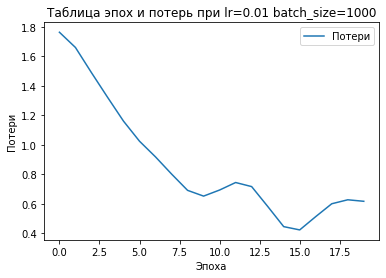

100%|██████████| 20/20 [00:04<00:00,  4.95it/s]


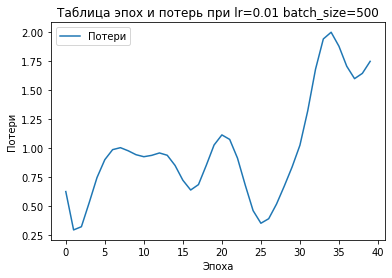

100%|██████████| 20/20 [00:16<00:00,  1.22it/s]


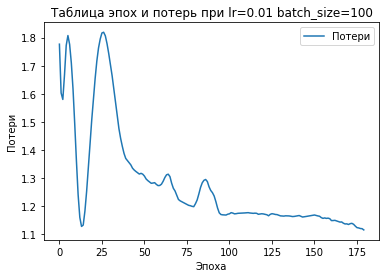

100%|██████████| 20/20 [00:02<00:00,  8.90it/s]


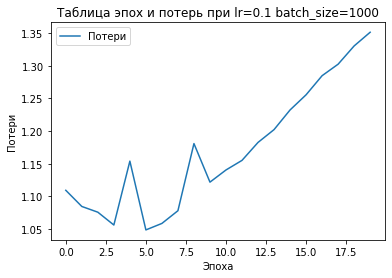

100%|██████████| 20/20 [00:03<00:00,  5.04it/s]


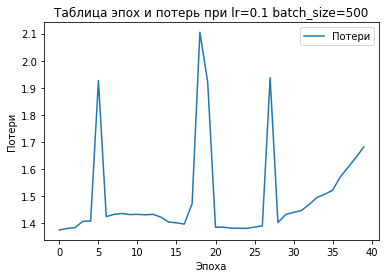

100%|██████████| 20/20 [00:18<00:00,  1.10it/s]


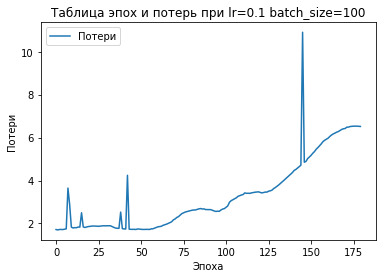

100%|██████████| 20/20 [00:02<00:00,  8.80it/s]


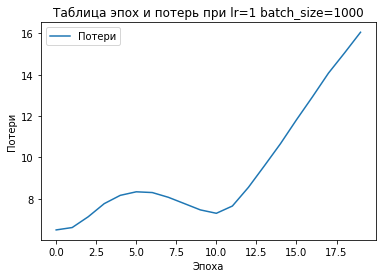

100%|██████████| 20/20 [00:04<00:00,  4.94it/s]


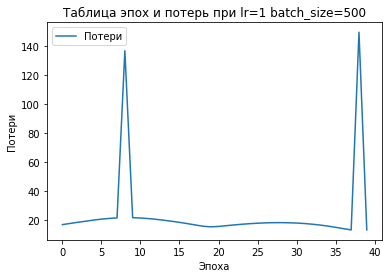

100%|██████████| 20/20 [00:17<00:00,  1.12it/s]


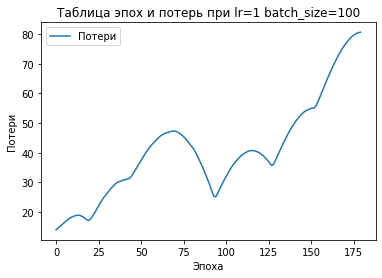

In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"

if device == "cuda":
    torch.cuda.manual_seed_all(1234)

lr_list=[0.01,0.1,1]
batch_size=[1000,500,100]
for LR in lr_list:
  for BZ in batch_size:
    data=torch.utils.data.DataLoader(x_train, batch_size=BZ,shuffle=True)
    val_data=torch.utils.data.DataLoader(x_val, batch_size=BZ,shuffle=True)
    optimizer = torch.optim.Adam(params=model.parameters() , lr=LR)
    epochs = 20
    model.train()
    loss_values = []
    loss_valid_values=[]
    for epoch in trange(epochs):
        for elems in data: 
         # optimizer.zero_grad()
          y_pred = model(x_train)
          loss = criterion(y_pred, y_train)
          loss_values.append(loss.item())
          pred = torch.max(y_pred, 1)[1].eq(y_train).sum()
          acc = pred * 100.0 / len(x_train)
          loss.backward()
          optimizer.step()
        
    plt.plot(loss_values)
    plt.title('Таблица эпох и потерь при lr='+str(LR) +" batch_size="+str(BZ))
    plt.xlabel('Эпоха')
    plt.ylabel('Потери')
    plt.legend(['Потери'])
    plt.show()
    

Оценить качество работы модели на тестовой выборке.

In [12]:
x_test = torch.Tensor(x_test).float()
y_test = [int(i) for i in y_test]
y_test = torch.Tensor(y_test).long()
model.eval()
with torch.no_grad():
    for i in range(20):
        y_pred = model(x_test)
        loss = criterion(y_pred, y_test)
        pred = torch.max(y_pred, 1)[1].eq(y_test).sum()
    print("Accuracy : {}%".format(100 * pred / len(x_test)))

Accuracy : 18.66666603088379%


Сделайте выводы по полученным результатам проведенных экспериментов. Какую модель из всех полученных стоит использовать?

In [14]:
LR = 0.01
BZ = 100

Сохранить обученную модель.

In [15]:
torch.save(model.state_dict(), os.path.join("/content/", "weight.pt"))

Выполните повторную инициализацию модели и загрузку весов. Продемонстрируйте работоспособность модели (пропустите через нее какой-то отзыв/рецензию и выведите результат).

In [16]:
model.load_state_dict(torch.load(os.path.join("/content/", "weight.pt")))
data = torch.utils.data.DataLoader(x_test, batch_size=BZ, shuffle=True)
model.eval()
text_list = []
with torch.no_grad():
    for i in range(20):
        y_pred = model(x_test)
        loss = criterion(y_pred, y_test)
        pred = torch.max(y_pred, 1)[1].eq(y_test).sum()
    print("Accuracy : {}%".format(100 * pred / len(x_test)))


Accuracy : 18.66666603088379%
